## Imports and Setups


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, BatchNormalization
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, Dropout, Add, MaxPooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

## Loading preprocessed data from '../../data/processed/FC211012_Azeem' path


In [ ]:
# Define image size and batch size
IMG_SIZE = (48, 48)
BATCH_SIZE = 32

# Define paths
train_dir = '../../data/processed/FC211012_Azeem/train'
test_dir = '../../data/processed/FC211012_Azeem/test'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixels [0,1]
    rotation_range=15,        # Random rotate ±15 degrees
    zoom_range=0.1,           # Zoom in/out by ±10%
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest'       # Fill in new pixels
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load testing/validation data
val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 24612 images belonging to 5 classes.
Found 6154 images belonging to 5 classes.


## Defining Mini-Xception architecture for 5 Emotion classes


In [ ]:

def Mini_XCEPTION(input_shape=(48, 48, 1), num_classes=5):
    input_layer = Input(shape=input_shape)

    # Initial Conv layer
    x = Conv2D(32, (3, 3), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual Modules
    for filters in [64, 128, 256]:

        residual = Conv2D(filters, (1, 1), strides=(2, 2), padding='same')(x)
        residual = BatchNormalization()(residual)

        # Separable conv block
        x = SeparableConv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = SeparableConv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        x = Add()([x, residual])

    # Final classification layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    return Model(input_layer, output_layer)


# Build the model
model = Mini_XCEPTION(input_shape=(48, 48, 1), num_classes=5)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 48, 48, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 48, 48, 32)        │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 48, 48, 32)        │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 48, 48, 32)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d              │ (None, 48, 48, 64)        │           2,400 │ activation[0][0]           │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 48, 48, 64)        │             256 │ separable_conv2d[0][0]     │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 48, 48, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_1            │ (None, 48, 48, 64)        │           4,736 │ activation_1[0][0]         │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 48, 48, 64)        │             256 │ separable_conv2d_1[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 24, 24, 64)        │           2,112 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 24, 24, 64)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 24, 24, 64)        │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 24, 24, 64)        │               0 │ max_pooling2d[0][0],       │
│                               │                           │                 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_2            │ (None, 24, 24, 128)       │           8,89

 Total params: 186,533 (728.64 KB)

 Trainable params: 183,781 (717.89 KB)

 Non-trainable params: 2,752 (10.75 KB)

## Compiling and training the model with Adam, EarlyStopping, and ModelCheckpoint


In [ ]:

# Compil the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='models/emotion_detection_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

C:\Users\moham\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2830 - loss: 1.8083
Epoch 1: val_loss improved from None to 1.53280, saving model to models/emotion_detection_model.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 1106s 1s/step - accuracy: 0.3263 - loss: 1.5900 - val_accuracy: 0.3708 - val_loss: 1.5328
Epoch 2/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.4481 - loss: 1.3123
Epoch 2: val_loss improved from 1.53280 to 1.21202, saving model to models/emotion_detection_model.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 401s 520ms/step - accuracy: 0.4801 - loss: 1.2528 - val_accuracy: 0.5036 - val_loss: 1.2120
Epoch 3/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.5452 - loss: 1.1291
Epoch 3: val_loss did not improve from 1.21202
770/770 ━━━━━━━━━━━━━━━━━━━━ 411s 534ms/step - accuracy: 0.5549 - loss: 1.1048 - val_accuracy: 0.5093 - val_loss: 1.3054
Epoch 4/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.5892 - loss: 1.0346
Epoch 4: val_loss improved from 1.21202 to 1.00988, saving model to models/emotion_detection_model.h5


770/770 ━━━━━━━━━━━━━━━━━━━━ 427s 555ms/step - accuracy: 0.5956 - loss: 1.0196 - val_accuracy: 0.5967 - val_loss: 1.0099
Epoch 5/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.6237 - loss: 0.9692
Epoch 5: val_loss did not improve from 1.00988
770/770 ━━━━━━━━━━━━━━━━━━━━ 408s 530ms/step - accuracy: 0.6227 - loss: 0.9681 - val_accuracy: 0.5614 - val_loss: 1.1416
Epoch 6/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6308 - loss: 0.9409
Epoch 6: val_loss did not improve from 1.00988
770/770 ━━━━━━━━━━━━━━━━━━━━ 424s 551ms/step - accuracy: 0.6336 - loss: 0.9336 - val_accuracy: 0.5832 - val_loss: 1.1067
Epoch 7/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.6466 - loss: 0.9107
Epoch 7: val_loss did not improve from 1.00988
770/770 ━━━━━━━━━━━━━━━━━━━━ 376s 488ms/step - accuracy: 0.6484 - loss: 0.9016 - val_accuracy: 0.5892 - val_loss: 1.0857
Epoch 8/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.6563 - loss: 0.8800
Epoch 8: val_loss impro

770/770 ━━━━━━━━━━━━━━━━━━━━ 380s 493ms/step - accuracy: 0.6516 - loss: 0.8875 - val_accuracy: 0.6292 - val_loss: 0.9234
Epoch 9/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.6674 - loss: 0.8677
Epoch 9: val_loss did not improve from 0.92343
770/770 ━━━━━━━━━━━━━━━━━━━━ 393s 510ms/step - accuracy: 0.6644 - loss: 0.8683 - val_accuracy: 0.6133 - val_loss: 1.0169
Epoch 10/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.6782 - loss: 0.8349
Epoch 10: val_loss did not improve from 0.92343
770/770 ━━━━━━━━━━━━━━━━━━━━ 395s 513ms/step - accuracy: 0.6731 - loss: 0.8477 - val_accuracy: 0.5730 - val_loss: 1.2176
Epoch 11/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6816 - loss: 0.8264
Epoch 11: val_loss did not improve from 0.92343
770/770 ━━━━━━━━━━━━━━━━━━━━ 375s 487ms/step - accuracy: 0.6780 - loss: 0.8328 - val_accuracy: 0.5567 - val_loss: 1.2366
Epoch 12/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6787 - loss: 0.8251
Epoch 12: val_loss

770/770 ━━━━━━━━━━━━━━━━━━━━ 381s 494ms/step - accuracy: 0.6797 - loss: 0.8259 - val_accuracy: 0.6667 - val_loss: 0.8813
Epoch 13/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6854 - loss: 0.8144
Epoch 13: val_loss did not improve from 0.88132
770/770 ━━━━━━━━━━━━━━━━━━━━ 367s 477ms/step - accuracy: 0.6896 - loss: 0.8048 - val_accuracy: 0.6053 - val_loss: 1.0644
Epoch 14/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6931 - loss: 0.7948
Epoch 14: val_loss did not improve from 0.88132
770/770 ━━━━━━━━━━━━━━━━━━━━ 519s 674ms/step - accuracy: 0.6887 - loss: 0.8032 - val_accuracy: 0.6082 - val_loss: 0.9728
Epoch 15/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.6936 - loss: 0.7948
Epoch 15: val_loss did not improve from 0.88132
770/770 ━━━━━━━━━━━━━━━━━━━━ 542s 704ms/step - accuracy: 0.6949 - loss: 0.7927 - val_accuracy: 0.6040 - val_loss: 1.0759
Epoch 16/30
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6971 - loss: 0.7817
Epoch 16: val_lo

## Saving and evaluating the best model


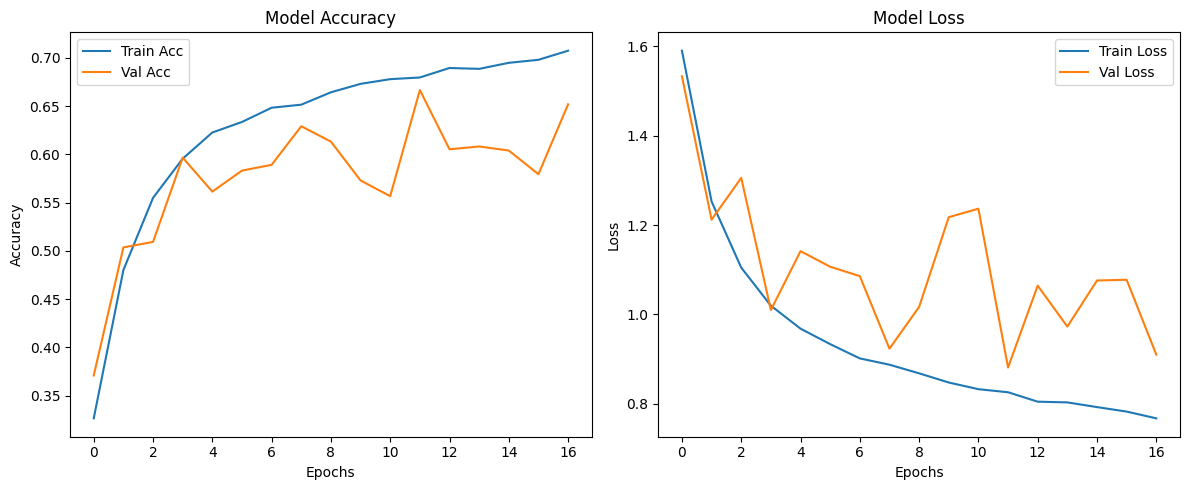

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# 1.Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# 2.Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Get class indices to labels mapping
class_indices = val_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Reset generator for fresh prediction
val_generator.reset()

# Predict class probabilities
y_probs = model.predict(val_generator, verbose=1)

# Get predicted and true labels
y_pred = np.argmax(y_probs, axis=1)
y_true = val_generator.classes

193/193 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step


## Print classification metrics


In [ ]:
report = classification_report(
    y_true, y_pred, target_names=idx_to_class.values())
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

       happy       0.79      0.84      0.82      1774
     neutral       0.64      0.54      0.59      1233
         sad       0.51      0.64      0.57      1247
    stressed       0.77      0.37      0.50      1069
    surprise       0.65      0.89      0.75       831

    accuracy                           0.67      6154
   macro avg       0.67      0.66      0.65      6154
weighted avg       0.68      0.67      0.66      6154



## Compute and plot confusion matrix


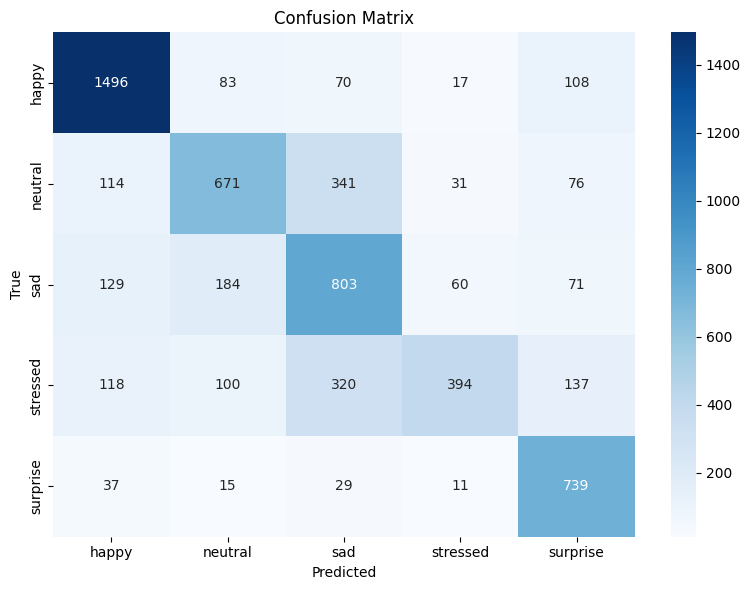

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=idx_to_class.values(),
            yticklabels=idx_to_class.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()